In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import math

from sklearn.model_selection import (train_test_split,KFold)
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
data07=pd.read_csv("TEDS-D-2007-DS0001-data-excel.tsv", sep='\t')
data08=pd.read_csv("TEDS-D-2008-DS0001-data-excel.tsv", sep='\t')
data09=pd.read_csv("TEDS-D-2009-DS0001-data-excel.tsv", sep='\t')
data10=pd.read_csv("TEDS-D-2010-DS0001-data-excel.tsv", sep='\t')
data11=pd.read_csv("TEDS-D-2011-DS0001-data-excel.tsv", sep='\t')
data12=pd.read_csv("TEDS-D-2012-DS0001-data-excel.csv")

In [3]:
sample07=data07.sample(n=1000)
sample08=data08.sample(n=1000)
sample09=data09.sample(n=1000)
sample10=data10.sample(n=1000)
sample11=data11.sample(n=1000)
sample12=data12.sample(n=1000)

In [4]:
frames=[sample07,sample08,sample09,sample10,sample11,sample12]
full_data=pd.concat(frames)

In [5]:
#convert age to mean age--one less dummy
age_dict={2:13, 3:16, 4:19, 5:23, 6:27, 7:32, 8:37, 9:42, 10:47, 11:52, 12:55}
def group_age(s):
    if s in age_dict.keys():
        return age_dict[s]
full_data['AGE']=full_data['AGE'].map(group_age)

#delete CASEID column
del full_data['CASEID']

#update REASON column to just 0 or 1's
#updating reason column to just 1 and 0's 
def reason_func(s):
    if s==1:
        return 1
    else:
        return 0
    #question- should those be strings or integers?
    
##replace NANs with -9
full_data=full_data.replace(np.nan, '-9')

full_data['REASON']=full_data['REASON'].map(reason_func)
full_data['REASON'].value_counts()

0    3287
1    2713
Name: REASON, dtype: int64

In [6]:
collist = full_data.columns.tolist()
collist.remove('ARRESTS')
collist.remove('DAYWAIT')
collist.remove('NOPRIOR')
collist.remove('NUMSUBS')
collist.remove('AGE')
collist.remove('LOS')
collist.remove('REASON')
cat_df = full_data[collist]

#make these numbers strings so that get dummies will work
for i in cat_df.columns:
    cat_df[i]=cat_df[i].astype(str)
#cat_df.dtypes

/Users/daniellediehl/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [7]:
df_with_dummies = pd.get_dummies( cat_df , prefix=cat_df.columns.tolist())
#df_with_dummies = pd.get_dummies( fake_num , prefix=fake_num.columns.tolist())

In [8]:
print "num of dummy columns", len(df_with_dummies.columns)
df_with_dummies

num of dummy columns 845


,ALCDRUG_0,ALCDRUG_1,ALCDRUG_2,ALCDRUG_3,ALCFLG_0,ALCFLG_1,AMPHFLG_0,AMPHFLG_1,BARBFLG_0,BARBFLG_1,...,SUB3_5,SUB3_6,SUB3_7,SUB3_8,SUB3_9,TRNQFLG_0,TRNQFLG_1,VET_-9,VET_1,VET_2
98919,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1399524,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [8]:
#add back the numeric columns (age, arrests, daywait, no prior, numsubs)
data=df_with_dummies
data['AGE']=full_data['AGE']
data['ARRESTS']=full_data['ARRESTS'].astype(int)
data['DAYWAIT']=full_data['DAYWAIT']
data['NOPRIOR']=full_data['NOPRIOR']
data['NUMSUBS']=full_data['NUMSUBS']
data['LOS']=full_data['LOS']
data['REASON']=full_data['REASON']


data.columns[400:500]
data.dtypes

ALCDRUG_0     uint8
ALCDRUG_1     uint8
ALCDRUG_2     uint8
ALCDRUG_3     uint8
ALCFLG_0      uint8
ALCFLG_1      uint8
AMPHFLG_0     uint8
AMPHFLG_1     uint8
BARBFLG_0     uint8
BARBFLG_1     uint8
BENZFLG_0     uint8
BENZFLG_1     uint8
CBSA_-9       uint8
CBSA_10180    uint8
CBSA_10420    uint8
CBSA_10580    uint8
CBSA_10740    uint8
CBSA_10780    uint8
CBSA_10900    uint8
CBSA_11100    uint8
CBSA_11260    uint8
CBSA_11300    uint8
CBSA_11340    uint8
CBSA_11460    uint8
CBSA_11700    uint8
CBSA_11780    uint8
CBSA_12100    uint8
CBSA_12260    uint8
CBSA_12420    uint8
CBSA_12540    uint8
              ...  
SUB3_10       uint8
SUB3_11       uint8
SUB3_12       uint8
SUB3_13       uint8
SUB3_14       uint8
SUB3_15       uint8
SUB3_16       uint8
SUB3_17       uint8
SUB3_18       uint8
SUB3_2        uint8
SUB3_20       uint8
SUB3_3        uint8
SUB3_4        uint8
SUB3_5        uint8
SUB3_6        uint8
SUB3_7        uint8
SUB3_8        uint8
SUB3_9        uint8
TRNQFLG_0     uint8


# Length of Stay

In [9]:
los_dict={1:38, 32:53, 33:76, 34:106, 35:151, 36:273, 37:366}
#bins: 1-15, 16-30, 31-45, 46-60, 61-90, 91-120, 121-180, 181-365, 366+
data['LOS'].value_counts()

def fix_LOS(s):
    if s in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        return 1
    if s in [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
        return 2
    else:
        return s
data['LOS']=data['LOS'].map(fix_LOS)
data['LOS'].value_counts()

1     2019
2      724
36     591
33     570
35     545
34     480
31     456
32     349
37     266
Name: LOS, dtype: int64

**SVR**

In [11]:
X_los=data[data.columns[data.columns!='LOS']]
y_los=data['LOS']

#X.columns
X_train_los, X_test_los, y_train_los, y_test_los = train_test_split(X_los,y_los,test_size = 0.33, random_state=42)

In [ ]:
svm2 = svm.SVC(gamma=0.001, C=100.)
svm2.fit(X_train_los, y_train_los)

In [17]:
svm2.score(X_test_los, y_test_los)

0.16363636363636364

**Random Forests**

In [12]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=0, max_features=20, max_depth=5)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train_los, y_train_los)

# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(X_test_los)

# Create actual english names for the plants for each predicted plant class
preds = clf.predict(X_test_los)

# View a list of the features and their importance scores

print 'train', clf.score(X_train_los, y_train_los, sample_weight=None)

print 'test', clf.score(X_test_los, y_test_los, sample_weight=None)

train 0.343532338308
test 0.336868686869


In [21]:
#sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), reverse=True)

**MLP**

In [13]:
mlp= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
mlp.fit(X_train_los, y_train_los) 
mlp.score(X_test_los,y_test_los)

0.38181818181818183

**KNN**

In [14]:
knn=neighbors.KNeighborsClassifier()
knn.fit(X_train_los, y_train_los)
knn.predict(X_test_los)

array([33,  1, 35, ...,  1,  2,  1])

In [15]:
knn.score(X_test_los,y_test_los)

0.31919191919191919

# Reason

**SVR**

In [85]:
X_r=data[data.columns[data.columns!='REASON']]
y_r=data['REASON']

#X.columns
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r,y_r,test_size = 0.33, random_state=42)

In [28]:
from sklearn import preprocessing
X_train_r_scaled = preprocessing.scale(X_train_r) 
X_test_r_scaled = preprocessing.scale(X_test_r)
#read about need to scale data for SVM

In [29]:
svm2 = svm.SVC(gamma=0.001, C=100.)

In [30]:
svm2.fit(X_train_r_scaled, y_train_r)  

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
#svm2.predict(X_test_r)
svm2.score(X_test_r_scaled, y_test_r)
#scaling the data decreased the score from 68 to 65 

0.6707070707070707

In [32]:
#try these
svm3 = svm.SVC(gamma=0.001, C=1)
svm3.fit(X_train_r_scaled, y_train_r)
svm3.score(X_test_r_scaled, y_test_r)


# SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),

0.67272727272727273

In [33]:
svm4 = svm.SVC(gamma=2, C=1)
svm4.fit(X_train_r_scaled, y_train_r)
svm4.score(X_test_r_scaled, y_test_r)

0.5505050505050505

In [34]:
svm5 = svm.SVC(kernel='linear', C=1)
svm5.fit(X_train_r_scaled, y_train_r)
svm5.score(X_test_r_scaled, y_test_r)

0.69090909090909092

In [35]:
svm6 = svm.SVC(kernel='rbf',gamma=1e-4, C=1000)
svm6.fit(X_train_r_scaled, y_train_r)
svm6.score(X_test_r_scaled, y_test_r)

0.69090909090909092

Cross Validation for SVR

In [36]:
# Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]}]
#                     #,
#                     #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
#                        scoring='%s_macro' % score)
#     clf.fit(X_train_r_scaled, y_train_r)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test_r, clf.predict(X_test_r_scaled)
#     print(classification_report(y_true, y_pred))
#     print()


**Random Forests**

In [38]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=0, max_features=40, max_depth=9)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train_r, y_train_r)

# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(X_test_r)

# Create actual english names for the plants for each predicted plant class
preds = clf.predict(X_test_r)

# View a list of the features and their importance scores

print 'train', clf.score(X_train_r, y_train_r, sample_weight=None)

print 'test', clf.score(X_test_r, y_test_r, sample_weight=None)

train 0.756218905473
test 0.642929292929


In [40]:
names=X_test_r.columns

sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), reverse=True)
#LOS is the most important in whether or not treatment was a success
#noprior is the second

[(0.0486, 'LOS'),
 (0.0408, 'SUB1_2'),
 (0.0316, 'ROUTE1_1'),
 (0.0283, 'SERVSETD_7'),
 (0.0238, 'SERVSETD_2'),
 (0.0202, 'DSMCRIT_3'),
 (0.0192, 'METHUSE_1'),
 (0.0149, 'SERVSETD_1'),
 (0.0128, 'PREG_2'),
 (0.0114, 'NUMSUBS'),
 (0.0111, 'PSYPROB_-9'),
 (0.0111, 'AGE'),
 (0.0108, 'PRIMINC_-9'),
 (0.0108, 'FREQ2_-9'),
 (0.0101, 'STFIPS_36'),
 (0.0101, 'ARRESTS'),
 (0.01, 'ALCDRUG_1'),
 (0.0097, 'REGION_1'),
 (0.0093, 'EMPLOY_1'),
 (0.0092, 'NOPRIOR'),
 (0.0086, 'ROUTE1_2'),
 (0.0083, 'STFIPS_51'),
 (0.0083, 'PSOURCE_7'),
 (0.0082, 'PSOURCE_1'),
 (0.0076, 'METHUSE_2'),
 (0.0074, 'SUB2_2'),
 (0.0074, 'PSYPROB_1'),
 (0.0073, 'PREG_-9'),
 (0.0073, 'CBSA_19740'),
 (0.0068, 'STFIPS_37'),
 (0.0066, 'FRSTUSE2_-9'),
 (0.0066, 'COKEFLG_1'),
 (0.0065, 'SERVSETD_6'),
 (0.0065, 'SERVSETD_5'),
 (0.0065, 'DSMCRIT_-9'),
 (0.0064, 'REGION_2'),
 (0.0064, 'OPSYNFLG_0'),
 (0.0064, 'DAYWAIT'),
 (0.0062, 'RACE_4'),
 (0.0061, 'RACE_5'),
 (0.0059, 'SUB3_1'),
 (0.0059, 'DSMCRIT_5'),
 (0.0058, 'SERVSETD_4'),
 (0

**MLP**

In [41]:
mlp= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [42]:
mlp.fit(X_train_r, y_train_r) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [43]:
mlp.score(X_test_r,y_test_r)

0.6994949494949495

In [44]:
mlp.classes_

array([0, 1])

In [ ]:
data['REASON'].value_counts()

In [86]:
mlp2= MLPClassifier(hidden_layer_sizes=(30,30,30), random_state=1)

In [87]:
mlp2.fit(X_train_r, y_train_r) 
mlp2.score(X_test_r,y_test_r)

0.68333333333333335

In [89]:
len(X_test_r)

9900

http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

**KNN**

In [45]:
knn=neighbors.KNeighborsClassifier()
knn.fit(X_train_r, y_train_r)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
knn.predict(X_test_r)

array([1, 1, 1, ..., 1, 1, 0])

In [47]:
knn.score(X_test_r, y_test_r)

0.59494949494949489

In [48]:
#cross validate to get k?

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors_list = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors_list:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_r, y_train_r, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 17


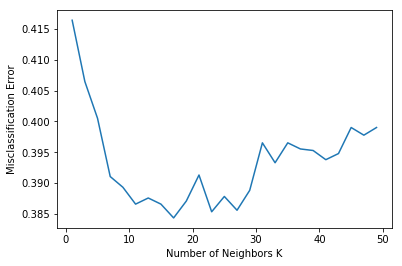

In [49]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors_list[MSE.index(min(MSE))]
print "The optimal number of neighbors is %d" % optimal_k

# plot misclassification error vs k
plt.plot(neighbors_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [52]:
knn=neighbors.KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_r, y_train_r)
knn.score(X_test_r, y_test_r)

0.59141414141414139

In [53]:
print mean_squared_error(knn.predict(X_test_r),y_test_r)

0.408585858586


**PCA**
- PCA does not seem to work well 

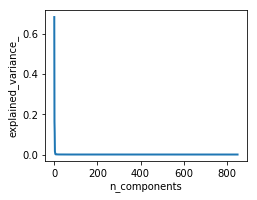

array([[ -1.45959488e-05,  -2.53671900e-04,   2.37924339e-04, ...,
          5.13374442e-03,   4.06149140e-04,   1.98984192e-02],
       [ -1.73741502e-04,   4.54649226e-03,  -2.53183114e-03, ...,
         -3.07088841e-02,  -3.58325274e-03,  -9.09625033e-01],
       [ -4.84097067e-05,  -8.62710415e-03,   7.14337093e-03, ...,
         -1.34725824e-02,   7.71091237e-03,  -4.09562020e-01],
       ..., 
       [  0.00000000e+00,   1.58669497e-03,   1.62210198e-16, ...,
         -2.71050543e-18,   2.03172795e-04,   2.30392962e-19],
       [  0.00000000e+00,   1.03837285e-01,   7.14966281e-15, ...,
         -9.02056208e-17,  -5.54860564e-02,   2.77555756e-17],
       [ -0.00000000e+00,  -3.08951231e-01,  -1.28126676e-14, ...,
         -0.00000000e+00,  -6.63898281e-02,  -8.32667268e-17]])

In [72]:
pca = PCA()
pca.fit(X_r)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()
pca.components_

# LOS as number

In [55]:
los_dict={31:38, 32:53, 33:76, 34:106, 35:151, 36:273, 37:366}
#bins: 31-45, 46-60, 61-90, 91-120, 121-180, 181-365, 366+
def conv_los(s):
    if s in los_dict.keys():
        return los_dict[s]
    else:
        return s
los_data=data
los_data['LOS']=los_data['LOS'].map(conv_los)

In [56]:
los_data['LOS'].value_counts()[:2]

273    579
76     572
Name: LOS, dtype: int64

In [57]:
X_l=los_data[los_data.columns[los_data.columns!='LOS']]
y_l=los_data['LOS']

#X.columns
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l,y_l,test_size = 0.33, random_state=42)

In [58]:
regr = linear_model.LinearRegression()
regr.fit(X_train_l, y_train_l)
y_pred_l = regr.predict(X_test_l)

In [59]:
print y_pred_l[:30]
print y_test_l[:30]

[ 160.77490234   87.50390625  118.55371094   16.30712891   44.93017578
  131.61328125   80.203125    191.76708984  -21.73730469  139.46240234
  159.8671875    24.47314453   89.23925781   15.375       126.80126953
   10.51708984   70.15087891   13.35693359  115.86083984   -6.29052734
  106.59082031   97.30859375  -83.09521484   52.98974609  103.81835938
   66.41064453   60.39013672  150.91552734   95.65576172   11.40673828]
1665741    366
679216     273
1237914    151
463492       8
1141814    273
804762     366
697722     366
786474     151
857537       4
1199016    106
162277     106
601679      76
1577445     38
820801     106
1301832    151
133794      13
1079179      7
274286       1
1276340    273
903757      76
1322860    366
848878      76
94723        8
832155       7
797049       5
240223       1
1232047      4
822230      38
20437       53
10669       21
Name: LOS, dtype: int64


In [60]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_l, y_pred_l))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_l, y_pred_l))

Mean squared error: 6836496246084654080.00
Variance score: -686011108413572.75


**SVR**

In [61]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

y_rbf = svr_rbf.fit(X_train_l, y_train_l).predict(X_test_l)



In [62]:
mean_squared_error(y_test_l, y_rbf)

9262.2398964944095

In [75]:
print y_rbf[:30]
print y_test_l

[ 102.78577939   55.40008472   86.26713722   77.43332281   87.1676948
  100.55277792   53.52143072   73.05925778   65.2026248    73.12045528
   85.7795092    86.69151749   86.73957625   88.14470302   88.30389093
   84.89717371   85.12021402   79.4127543    84.53344068   84.80285062
   77.14715884   91.90547695   57.21335656   65.88820424   84.06615882
   73.63082513   71.06298519   77.46403097   82.8683923    81.97119474]
1665741    366
679216     273
1237914    151
463492       8
1141814    273
804762     366
697722     366
786474     151
857537       4
1199016    106
162277     106
601679      76
1577445     38
820801     106
1301832    151
133794      13
1079179      7
274286       1
1276340    273
903757      76
1322860    366
848878      76
94723        8
832155       7
797049       5
240223       1
1232047      4
822230      38
20437       53
10669       21
          ... 
1556561     53
1444253    366
250524     106
112620       2
722386     106
1122791     28
1303614      1
5021

In [63]:
# svr_lin = SVR(kernel='linear', C=1e3)
# y_lin = svr_lin.fit(X_train_l, y_train_l).predict(X_test_l)

In [64]:
# mean_squared_error(y_test_l, y_lin)

In [65]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_poly = svr_poly.fit(X_train_l, y_train_l).predict(X_test_l)

In [66]:
mean_squared_error(y_test_l, y_poly)

8721.1179197647089